Import libraries

In [0]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tqdm.notebook import tqdm
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image

Loss and Metric Functions

In [0]:
def dice_coeff(y_true, y_pred):
  smooth = 1.
  y_true_f = tf.reshape(y_true, [-1])
  y_pred_f = tf.reshape(y_pred, [-1])
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
  return score

In [0]:
def dice_loss(y_true, y_pred):
  loss = 1 - dice_coeff(y_true, y_pred)
  return loss

In [0]:
def bce_dice_loss(y_true, y_pred):
  loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
  return loss

Load images

In [0]:
images_directory = '/content/drive/My Drive/Water Bodies Satellite Images/Images'

In [0]:
images_to_load = []
for root, directory, file in os.walk(images_directory):
  for f in file:
    images_to_load.append(root + '/' + f)

In [0]:
images_train = []
for file in tqdm(sorted(images_to_load[0:round(len(images_to_load)*.8)])):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(file, target_size=(128,128))
    image = tf.keras.preprocessing.image.img_to_array(image)/255.0
    images_train.append(image)

images_train = np.array(images_train)

In [0]:
images_test = []
for file in tqdm(sorted(images_to_load[round(len(images_to_load)*.8):])):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(file, target_size=(128,128))
    image = tf.keras.preprocessing.image.img_to_array(image)/255.0
    images_test.append(image)

images_test = np.array(images_test)

Load masks

In [0]:
masks_directory = '/content/drive/My Drive/Water Bodies Satellite Images/Masks'

In [0]:
masks_to_load = []
for root, directory, file in os.walk(masks_directory):
  for f in file:
    masks_to_load.append(root + '/' + f)

In [0]:
masks_train = []
for file in tqdm(sorted(masks_to_load[0:round(len(masks_to_load)*.8)])):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    mask = tf.keras.preprocessing.image.load_img(file, target_size=(128,128))
    mask = tf.keras.preprocessing.image.img_to_array(mask)/255.0
    masks_train.append(mask)

masks_train = np.array(masks_train)

In [0]:
masks_test = []
for file in tqdm(sorted(masks_to_load[round(len(masks_to_load)*.8):])):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    mask = tf.keras.preprocessing.image.load_img(file, target_size=(128,128))
    mask = tf.keras.preprocessing.image.img_to_array(mask)/255.0
    masks_test.append(mask)

masks_test = np.array(masks_test)

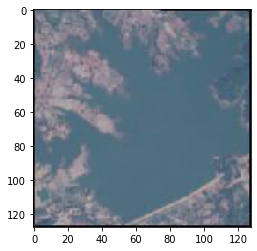

In [0]:
plt.imshow(images_train[0])
plt.show()

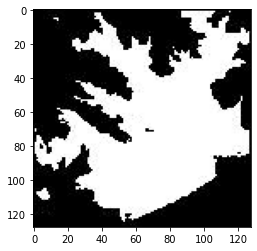

In [0]:
plt.imshow(masks_train[0])
plt.show()

U-NET

In [0]:
image_width = 128
image_height = 128
image_channels = 3
filter_multiplier = 16
epochs = 100

In [0]:
inputs = Input(shape=(image_width, image_height, image_channels))
#1
first_convolution = Conv2D(filters=1*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(inputs)
first_convolution = Conv2D(filters=1*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(first_convolution)
first_pooling = MaxPooling2D(pool_size=(2,2))(first_convolution)
first_pooling = Dropout(0.5)(first_pooling)

#2
second_convolution = Conv2D(filters=2*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(first_pooling)
second_convolution = Conv2D(filters=2*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(second_convolution)
second_pooling = MaxPooling2D(pool_size=(2,2))(second_convolution)
second_pooling = Dropout(0.5)(second_pooling)

#3
third_convolution = Conv2D(filters=4*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(second_pooling)
third_convolution = Conv2D(filters=4*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(third_convolution)
third_pooling = MaxPooling2D(pool_size=(2,2))(third_convolution)
third_pooling = Dropout(0.5)(third_pooling)

#4
fourth_convolution = Conv2D(filters=8*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(third_pooling)
fourth_convolution = Conv2D(filters=8*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(fourth_convolution)
fourth_pooling = MaxPooling2D(pool_size=(2,2))(fourth_convolution)
fourth_pooling = Dropout(0.5)(fourth_pooling)

#5
fifth_convolution = Conv2D(filters=16*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(fourth_pooling)
fifth_convolution = Conv2D(filters=16*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(fifth_convolution)

#6
sixth_deconvolution = Conv2DTranspose(filters=8*filter_multiplier, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu' )(fifth_convolution)
sixth_convolution = concatenate([sixth_deconvolution, fourth_convolution])
sixth_convolution = Dropout(0.5)(sixth_convolution)
sixth_convolution = Conv2D(filters=8*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(sixth_convolution)
sixth_convolution = Conv2D(filters=8*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(sixth_convolution)


#7
seventh_deconvolution = Conv2DTranspose(filters=4*filter_multiplier, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu' )(sixth_convolution)
seventh_convolution = concatenate([third_convolution, seventh_deconvolution])
seventh_convolution = Dropout(0.5)(seventh_convolution)
seventh_convolution = Conv2D(filters=4*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(seventh_convolution)
seventh_convolution = Conv2D(filters=4*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(seventh_convolution)

#8
eigth_deconvolution = Conv2DTranspose(filters=2*filter_multiplier, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu' )(seventh_convolution)
eigth_convolution = concatenate([eigth_deconvolution, second_convolution])
eigth_convolution = Dropout(0.5)(eigth_convolution)
eigth_convolution = Conv2D(filters=2*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(eigth_convolution)
eigth_convolution = Conv2D(filters=2*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(eigth_convolution)

#9
ninth_deconvolution = Conv2DTranspose(filters=1*filter_multiplier, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu' )(eigth_convolution)
ninth_convolution = concatenate([ninth_deconvolution, first_convolution])
ninth_convolution = Dropout(0.5)(ninth_convolution)
ninth_convolution = Conv2D(filters=1*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(ninth_convolution)
ninth_convolution = Conv2D(filters=1*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(ninth_convolution)

#10
output = Conv2D(filters = 3, kernel_size=(1,1), padding='valid', activation='sigmoid')(ninth_convolution)

In [0]:
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_39[0][0]                  
____________________________________________________________________________________________

In [0]:
history = model.fit(images_train, masks_train, epochs = epochs, validation_data=(images_test, masks_test))

Epoch 1/100
72/72 [==============================] - 5s 70ms/step - loss: 1.1253 - dice_loss: 0.5783 - val_loss: 0.9929 - val_dice_loss: 0.4457
Epoch 2/100
72/72 [==============================] - 4s 58ms/step - loss: 0.8789 - dice_loss: 0.4149 - val_loss: 0.7112 - val_dice_loss: 0.2882
Epoch 3/100
72/72 [==============================] - 4s 59ms/step - loss: 0.7618 - dice_loss: 0.3474 - val_loss: 0.6966 - val_dice_loss: 0.2639
Epoch 4/100
72/72 [==============================] - 4s 58ms/step - loss: 0.7143 - dice_loss: 0.3230 - val_loss: 0.8425 - val_dice_loss: 0.3209
Epoch 5/100
72/72 [==============================] - 4s 58ms/step - loss: 0.6678 - dice_loss: 0.2965 - val_loss: 0.8956 - val_dice_loss: 0.3587
Epoch 6/100
72/72 [==============================] - 4s 58ms/step - loss: 0.7153 - dice_loss: 0.3209 - val_loss: 0.7950 - val_dice_loss: 0.3114
Epoch 7/100
72/72 [==============================] - 4s 58ms/step - loss: 0.6211 - dice_loss: 0.2750 - val_loss: 0.6022 - val_dice_loss:

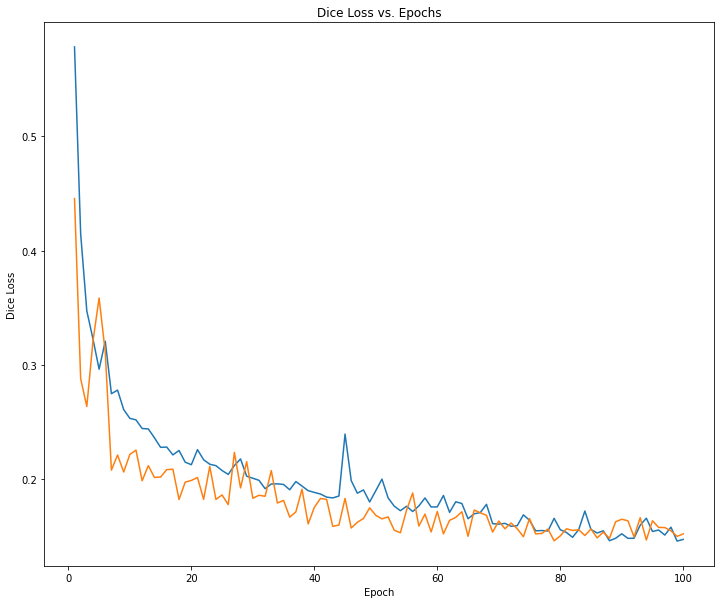

In [0]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']
epochs_range = range(1, epochs+1)

plt.figure(figsize=(12, 10))
plt.plot(epochs_range, dice, label='Training')
plt.plot(epochs_range, val_dice, label='Validation')
plt.title('Dice Loss vs. Epochs')
plt.ylabel('Dice Loss')
plt.xlabel('Epoch')
plt.show()

In [0]:
predictions = model.predict(images_test)

In [0]:
predictions = np.mean(predictions, axis=3)

In [0]:
predictions[predictions>=predictions.mean()] = 1
predictions[predictions<predictions.mean()] = 0

In [0]:
predictions = np.stack((predictions,)*3, axis=3)

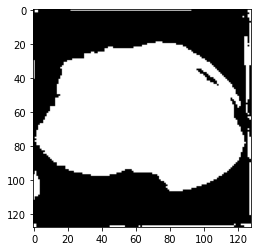

In [0]:
plt.imshow(predictions[15])
plt.show()

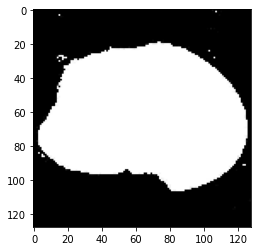

In [0]:
plt.imshow(masks_test[15])
plt.show()

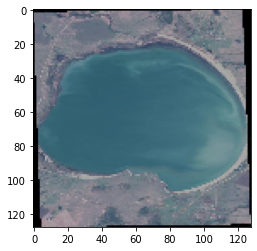

In [0]:
plt.imshow(images_test[15])

Calculate Water Function

In [0]:
def calculate_water(predicted_mask):
  white = len(predicted_mask[predicted_mask>=.5])
  black = len(predicted_mask[predicted_mask<.5])
  water_percentage = white / (white+black)
  return round(water_percentage,5)

In [0]:
calculate_water(predictions[1])

0.57104

In [0]:
calculate_water(masks_test[1])

0.60193

Calculate Water

In [0]:
water_train = [calculate_water(mask)*100 for mask in masks_train]
water_test = [calculate_water(mask) * 100 for mask in masks_test]
water_predicted = [calculate_water(mask) *100 for mask in predictions]

In [0]:
results = pd.DataFrame({'Image':sorted(images_to_load[round(len(images_to_load)*.8):]),
                        'Original Water Percentage':water_test,
                        'Predicted Water Percentage':water_predicted})

In [0]:
results['Error Percentage'] = 100 * abs(results['Original Water Percentage']-results['Predicted Water Percentage']) / results['Original Water Percentage']

In [0]:
results['Error Percentage'].mean()

19.32699315389668